Amdahl's Law Applied
==================


* Ideally: code on 4 cores runs 4x faster than on 1.
* That is rare. There is a name for it: "Embarassingly Parallel."
* Usually, application *Speedup* is limited by how it written (designer's fault.)
* When using large numbers or processes and processors, this hits *HARD.*



Speedup
-------------

If you have a single processor to run code, then assuming perfect parallism (the so-called "embarrasingly parallel" case) then your code will run twice as fast on two processors, four times as fast on four, etc... This is the ideal case. Much real-life code has "dependencies" that limit speedup.

Speedup of a task, when adding processors is limited by how much of the code can run in parallel. If you had an infinite number of processors to apply to a problem, then performance is limited by the p the parallelizability of your code.

The graph below plots the speedup available against the degree to which the code is parallelizable (from 5% to 95% in steps of 5%.) For example, if the algorithm is only 50% parallelizable, then throwing an infinite number of processors at the problem will give you a 25% speedup ( 1.25 on the plot.) so it isn't worthwhile.

Note that, towards the right edge of the plot, the speedup is nearly vertical. This means that the difference in real life performance near that limit, say between 98% and 99% parallelizable, is huge (as in closer to ten fold than 10%)


In [3]:
import numpy as np
from matplotlib import pyplot as plt

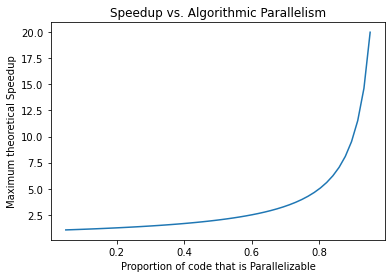

In [4]:
%matplotlib inline
P = np.linspace(0.05,0.95)

speedup = lambda p: 1/(1-p)

S = np.vectorize(speedup)(P)

f1=plt.figure()
plt.plot(P,S)
plt.xlabel("Proportion of code that is Parallelizable")
plt.ylabel("Maximum theoretical Speedup")
plt.title( "Speedup vs. Algorithmic Parallelism")

plt.show()




What is Amdahl's Law?
---------------------------------

* Speedup a program can achieve is limited by the level of parallelization of its design.

* If code is 95% parallelized, then 5%, or 1 part in 20, is serial... that means, no matter how many processors are put on the job, eventually you are limited by the part that isn't parallel. It's asymptotic speedup (that it will never reach, is 20x.)

* The more processors you want to use, the more this law bites.


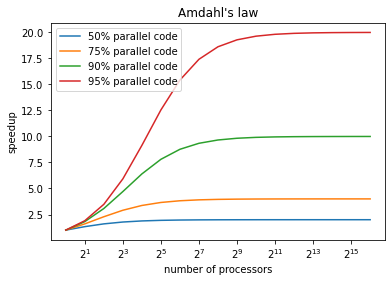

In [5]:
nproc=np.logspace(0,16,num=17,base=2,dtype=int)

# p is the parallelizable part of the code, that can be sped up.
# n is the number of processors applied to the problem.
def t(p,n):
    return (1-p)+(p)/n

A = {}
for p in [ 0.5, 0.75, 0.9, 0.95 ]:
    i="%d" %p
    A[i] =np.vectorize( lambda n: 1/t(p,n) )(nproc)
    plt.plot(nproc,A[i], label="%02d%% parallel code" %int(p*100))

plt.xscale('log',base=2)
plt.xlabel("number of processors")
plt.ylabel("speedup")
plt.title("Amdahl's law")
plt.legend()
plt.show()


Large Numbers of Processors Need High Parallelism
---------------------------------------------------------------------------

In the previous picture, we could see that:

* we could never get more than a 20 fold speedup if 5% of the code is serial. 
* To use higher number of processors, we need higher and higher levels of parallelization. 
* There limit is, of course, 100% parallel code, usually referred to as "embarrassingly parallel."  
* to use larger numbers of processors, the ideal is to write embarassingly parallel code.

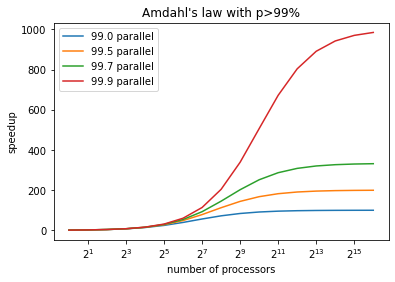

In [6]:
A = {}
for p in [ 0.99, 0.995, 0.997, 0.999 ]:
    i="%d" %p
    A[i] =np.vectorize( lambda n: 1/t(p,n) )(nproc)
    plt.plot(nproc,A[i], label=f"{p*100} parallel" )

plt.xscale('log',base=2)
plt.xlabel("number of processors")
plt.ylabel("speedup")
plt.title("Amdahl's law with p>99%")
plt.legend()
plt.show()

Serial Example
---------------------

Below is a simple example of a python snippet that we want to accelerate.  It does a math function and calculates "tot" over a range of numbers. 

In [7]:
%%time
max=1000000
counter=0
tot=1

def count():
   global tot,counter
   counter=0
   while counter < max:
      tot += 1/tot
      counter += 1

count()
print( f" total is: {tot}" )

 total is: 1414.21661385363
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 160 ms



So it calculates the answer, and it does it in 122 milliseconds, entirely in user space (0 ns of system time.)
We want to make it faster, so let's add threading.

* import threads
* run four threads in parallel.

should finish four times faster, right?


In [8]:
%%time
import threading

max=1000000
tot=1

def count():
   global tot
   counter=0
   while counter < max:
      tot += 1/tot
      counter += 1

threadMax=4
threads = []
threadNumber=1
while threadNumber < threadMax:
   t = threading.Thread(target=count)
   threads.append(t)
   threadNumber += 1

for t in threads:
    t.start()

for t in threads:
    t.join()

print( f" total is: {tot}" )

 total is: 2449.49161668406
CPU times: user 404 ms, sys: 3.8 ms, total: 408 ms
Wall time: 405 ms



OK, so the answer is wrong, and it took 3 times more cpu time to do it. How come?

* Because the overhead for setting up the threads is much more than the size of the problem. (amortization)
* But the answer is still wrong. Why?
  * the four tasks are changing the same counters and writing on eachothers work, 
  * it is a pile of race conditions. 
  
* How can we get the parallel code to get the right answer?

* We add locks, to serialize access to the variables the tasks are contending for.

In [9]:
%%time
import threading

max=1000000
counter=0
tot=1
counterLock = threading.Lock()
totLock = threading.Lock()

def count():
   global counter,tot
   while counter < max:
      totLock.acquire()
      tot += 1/tot
      totLock.release()

      counterLock.acquire()
      counter += 1
      counterLock.release()

threadMax=4
threads = []
threadNumber=1
while threadNumber < threadMax:
   t = threading.Thread(target=count)
   threads.append(t)
   threadNumber += 1

for t in threads:
    t.start()

for t in threads:
    t.join()

print( f" total is: {tot}" )

 total is: 1414.2180280637874
CPU times: user 2.7 s, sys: 2.3 s, total: 5 s
Wall time: 2.78 s


OK, now instead of 3 times slower it is now almost 20 times slower, and spending half the time in the kernel,
but the answer is correct. Why did synchronizing access to get the correct the answer make the cpu time double? 

**locking is expensive** To parallelize code, use locks sparingly.  locks are signs of serial code, and serial code fundamentally limits performance. 

In [4]:
%%time

import threading

max=1000000
counter=0
tot=1
critLock = threading.Lock()

def count():
   global counter,tot
   while counter < max:
      critLock.acquire()
      tot += 1/tot
      counter += 1
      critLock.release()

threadMax=4
threads = []
threadNumber=1
while threadNumber < threadMax:
   t = threading.Thread(target=count)
   threads.append(t)
   threadNumber += 1

for t in threads:
    t.start()

for t in threads:
    t.join()

print( f" total is: {tot}" )


 total is: 1414.2180280637874
CPU times: user 687 ms, sys: 810 ms, total: 1.5 s
Wall time: 917 ms


Here, instead of using a lock for each variable, we use the concept of a shared lock for when both variables.  
It eliminates about 40% of the execution time, so now it is only 9x slower than serial.

## NEWS FLASH: Serial 9x Faster than Parallel!

* Sometimes the thing you are trying to do is inherently serial. 
* Do something else instead.
* more hardware can slow things down because of co-ordination.
* locks are hard to get right, and can super easily kill performance.
* Also: headlines never tell the whole truth.



Summary
--------------

* Application design limits speedup.

* **Embarassingly Parallel** is the gold standard.

* *almost all parallel*, counts for little.

* Locks, joins, waits... they mean you failed to do the above.

* (Synchronous) API calls... mean you failed to do the above.

* Every small percentage of synchronization or global state, limits ultimate performance. 

* As the number of processes and processors rises, these small things dominate.
  
* locks, joins, waits... are all expensive, in terms of cpu time. They add overhead to any application. If you use them, make sure they are worth it, and amortize them by making them as coarse as possible.

* Ideally, try to formulate the algorithm so there are no synchronization points.


## Relevance?

Note that on our main cluster (ddsr.cmc) the configuration is 128 processors:

* 16 processors / node
* 8 nodes in the cluster
* 600 configurations/node (identical on all nodes)
* ~900 processes/node = 7200 processes in the application.
* at 7200 processes, 99.9% parallel isn't good enough to make good use of hardware.
* At this scale, you really want p to be around 99.99%...


## So Sarracenia is Not a Parallel App!


It is just an ordinary python script that launches processes. It's not a real parallel app.

* it is not based on threads !
* it does not use global locks, no joins, no synchronization!
* it is not leveraging multiprocessing!
* it is launching completely independent processes that never synchronize!

### Yes, Exactly.


## THANKS!


light reading:

* https://en.wikipedia.org/wiki/Amdahl%27s_law
* https://jenkov.com/tutorials/java-concurrency/amdahls-law.html
